In [494]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [495]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.2832, 0.1959, 0.1312, 0.2026, 0.0918, 0.0953],
        [0.0785, 0.0781, 0.2195, 0.2727, 0.1358, 0.2154],
        [0.0457, 0.3090, 0.0403, 0.3376, 0.0332, 0.2342],
        [0.3356, 0.0469, 0.3020, 0.0779, 0.0953, 0.1423],
        [0.2007, 0.0975, 0.1588, 0.1203, 0.2282, 0.1946]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [496]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.attention_weights = nn.Linear(n_features, 1, bias=False)
        self.interaction_tensors = nn.Parameter(torch.randn(n_features, n_features, n_features, n_features + 1))
        self.topk_num = 1
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Establish normalized subgroups
        norm_subgroups = torch.cat((state_tensor.unsqueeze(-2), previous_transition_tensor), dim=1)
        batch_size, num_groups, n_features = norm_subgroups.shape
        
        # Compute scores for each normalized subgroup
        scores = self.attention_weights(norm_subgroups).sum(-1) # [batch_size, num_groups]
        
        weights = torch.softmax(scores,dim = -1) # [batch_size, num_groups]
        
        selected_interaction_tensors = self.interaction_tensors
        selected_norm_subgroups = norm_subgroups

        #selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
        
        selected_transition_tensors = (torch.mul(selected_interaction_tensors, selected_norm_subgroups.permute(0,2,1).unsqueeze(1).unsqueeze(1))).sum(-2)
        
        # We need a single transition tensor so we will average this as well
        #selected_transition_tensor = torch.einsum('bs,bjks->bjk', weights,selected_transition_tensors)
        
        selected_transition_tensor = (torch.mul(selected_transition_tensors, weights.unsqueeze(-2).unsqueeze(-2))).sum(-1)
        # Generate state tensor from the transition tensor
        # Unsqueezing state_tensor to make it [batch_size, n_features, 1] for matrix multiplication
        state_tensor_unsqueezed = state_tensor.unsqueeze(2)

        # Performing batch matrix multiplication
        new_state_tensor_bmm = torch.bmm(selected_transition_tensor, state_tensor_unsqueezed)

        # Squeezing the result to get rid of the extra dimension, resulting in [batch_size, n_features]
        new_state_tensor = new_state_tensor_bmm.squeeze(2)
    
        softmax_tensor = torch.softmax(new_state_tensor * n_features, dim = 1)
        
        return softmax_tensor, selected_transition_tensor


    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


# Sequence-to-Sequence Check

In [497]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)


print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


In [498]:
batch_size = 13
n = 16
slices = 17

weights = torch.rand(batch_size,slices)
selected_transition_tensors = torch.rand(batch_size, n, n ,slices)

selected_transition_tensor = torch.einsum('bs,bjks->bjk', weights,selected_transition_tensors)

alt = (selected_transition_tensors * weights.unsqueeze(-2).unsqueeze(-2)).sum(-1)
alt3 = (torch.mul(selected_transition_tensors, weights.unsqueeze(-2).unsqueeze(-2))).sum(-1)
print(alt3[5,6])
print(selected_transition_tensor[5,6])


tensor([5.1621, 2.9759, 3.4055, 4.0199, 3.9542, 4.9271, 4.0877, 4.7487, 3.9336,
        2.8160, 5.6277, 4.7673, 4.5641, 5.0604, 4.5755, 3.7729])
tensor([5.1621, 2.9759, 3.4055, 4.0199, 3.9542, 4.9271, 4.0877, 4.7487, 3.9336,
        2.8160, 5.6277, 4.7673, 4.5641, 5.0604, 4.5755, 3.7729])


In [499]:
selected_interaction_tensors = torch.rand(n,n,n,slices)
selected_norm_subgroups = torch.rand(batch_size,slices, n)

selected_transition_tensors = torch.einsum('ijks,bsi->bjks', selected_interaction_tensors, selected_norm_subgroups)
selected_transition_tensors2 = torch.einsum('ijks,bks->bijs', selected_interaction_tensors, selected_norm_subgroups.permute(0,2,1))

alt2 = (selected_interaction_tensors * selected_norm_subgroups.permute(0,2,1).unsqueeze(1).unsqueeze(1)).sum(-2)
print(alt2.shape)
print(selected_transition_tensors[5,6,2])
print(selected_transition_tensors2[5,6,2])
print(alt2[5,6,2])


torch.Size([13, 16, 16, 17])
tensor([2.6469, 4.2753, 3.9302, 3.8398, 4.0154, 3.6772, 5.4100, 3.1397, 5.8419,
        4.1130, 3.5744, 3.8774, 4.1916, 5.2858, 4.9385, 5.1919, 4.0391])
tensor([3.7266, 2.8916, 5.0649, 3.6284, 2.8552, 3.1125, 6.3246, 4.8832, 3.4423,
        3.3809, 3.8099, 2.0166, 4.3717, 5.0427, 4.1490, 4.6321, 4.0308])
tensor([3.7266, 2.8916, 5.0649, 3.6284, 2.8552, 3.1125, 6.3246, 4.8832, 3.4423,
        3.3809, 3.8099, 2.0166, 4.3717, 5.0427, 4.1490, 4.6321, 4.0308])


In [500]:
i, j, k = 14, 12, 17

tensor_a = torch.rand(i,k)
tensor_b = torch.rand(k,j)

option1 = torch.matmul(tensor_a, tensor_b)
option2 = torch.einsum('ik,kj -> ij',tensor_a, tensor_b)
option3 = tensor_a@tensor_b
option4 = (tensor_a.unsqueeze(-1) * tensor_b).sum(dim=1)

print(option1[5,2])
print(option2[5,2])
print(option3[5,2])
print(option4[5,2])

tensor(5.1369)
tensor(5.1369)
tensor(5.1369)
tensor(5.1369)


In [501]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(x)
        
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-----------------------  ------------  ------------  ------------  ------------  ------------  ------------  
        model_inference        14.38%      28.932ms       100.00%     201.214ms     201.214ms             1  
              aten::sum        35.93%      72.300ms        38.01%      76.473ms     398.297us           192  
              aten::mul        29.90%      60.159ms        30.92%      62.209ms     324.005us           192  
           aten::linear         0.42%     842.000us         3.36%       6.762ms     105.656us            64  
          aten::softmax         0.36%     724.000us         3.09%       6.209ms      48.508us           128  
         aten::_softmax         2.77%       5.571ms         2.77%       5.571ms      43.523us           128  
        at

## Consistency Check

In [502]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch.randn(batch, n_features, n_features)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([-0.6060, -1.2720, -1.2180, -1.2397])
tensor([7.5109e-04, 5.3206e-05, 6.1816e-03, 9.9301e-01],
       grad_fn=<SliceBackward0>)
tensor([7.5109e-04, 5.3206e-05, 6.1816e-03, 9.9301e-01],
       grad_fn=<SliceBackward0>)


This should be the same as if we just look at the batches independently

In [503]:
batch = 2
transition_tensor = transition_tensor[0:2,:,:]
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([7.5109e-04, 5.3206e-05, 6.1816e-03, 9.9301e-01],
       grad_fn=<SliceBackward0>)

In [504]:
states = []
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

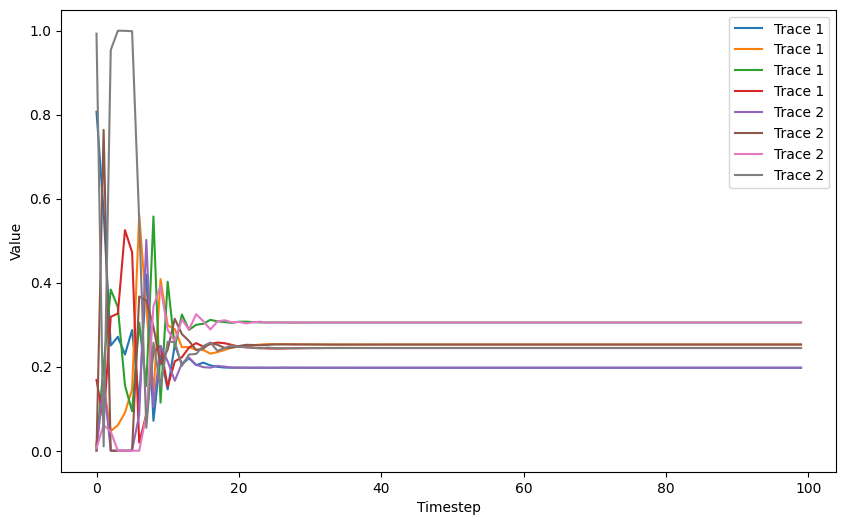

In [505]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

# Example Training

## Simple Data Generation

In [506]:
import numpy as np
import torch

def generate_normalized_multivariate_time_series(n_features, total_length, amplitude=1.0):
    t = np.linspace(0, 100 * np.pi, total_length)
    series = np.zeros((total_length, n_features))
    for i in range(n_features):
        series[:, i] = amplitude * np.cos(t * (i + 1) / n_features) + 10
    
    # Normalize such that each timestep's values sum to 1
    series_sum = np.sum(series, axis=1, keepdims=True)
    series_normalized = series / series_sum
    
    return series_normalized

def segment_time_series(series, length):
    # Assuming series is a numpy array of shape [total_length, n_features]
    total_length, n_features = series.shape
    segments = []
    for start in range(0, total_length - length, length):
        segment = series[start:start + length]
        segments.append(segment)
    return np.stack(segments)


In [507]:
n_features = 4
length = 64  # Segment length
total_length = 1024  # Arbitrary total length for the generated series

# Generate and segment the time series
series = generate_normalized_multivariate_time_series(n_features, total_length)
series_x = series[:-1,]
series_y = series[1:,]

segments_x = segment_time_series(series_x, length)
segments_y = segment_time_series(series_y, length)

# Convert to tensors
segments_tensor_x = torch.tensor(segments_x, dtype=torch.float)
segments_tensor_y = torch.tensor(segments_y, dtype=torch.float)

# Prepare inputs and targets
X = segments_tensor_x
# Shift segments to the right by one timestep to create the targets
Y =  segments_tensor_y


In [508]:
from torch import nn, optim

# Model
model = NeuralCoilLayer(
    n_features = n_features
)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs, transition_tensor = model(X)
    loss = criterion(outputs, Y)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')


Epoch [10/1000], Loss: 0.0002184117038268596
Epoch [20/1000], Loss: 0.00023509592574555427
Epoch [30/1000], Loss: 0.0001780418970156461
Epoch [40/1000], Loss: 0.0001676565589150414
Epoch [50/1000], Loss: 0.00014586937322746962
Epoch [60/1000], Loss: 0.00012743542902171612
Epoch [70/1000], Loss: 0.00010461370402481407
Epoch [80/1000], Loss: 7.444529910571873e-05
Epoch [90/1000], Loss: 5.903555211261846e-05
Epoch [100/1000], Loss: 4.8104175220942125e-05
Epoch [110/1000], Loss: 3.952764382120222e-05
Epoch [120/1000], Loss: 3.275294147897512e-05
Epoch [130/1000], Loss: 2.794418287521694e-05
Epoch [140/1000], Loss: 2.4610872060293332e-05
Epoch [150/1000], Loss: 2.233318446087651e-05
Epoch [160/1000], Loss: 2.076125929306727e-05
Epoch [170/1000], Loss: 1.9656419681268744e-05
Epoch [180/1000], Loss: 1.8851285858545452e-05
Epoch [190/1000], Loss: 1.823713319026865e-05
Epoch [200/1000], Loss: 1.774609881977085e-05
Epoch [210/1000], Loss: 1.7337149984086864e-05
Epoch [220/1000], Loss: 1.69857576

In [509]:
import plotly.graph_objects as go

def plot_model_output_vs_target(model_outputs, targets, batch_index=0, feature_index=0):
    # Extract the specified feature for the given batch from both the model outputs and targets
    model_output_series = model_outputs[batch_index, :, feature_index].detach().numpy()
    target_series = targets[batch_index, :, feature_index].numpy()
    
    # Create a range for the x-axis (timesteps)
    timesteps = list(range(model_output_series.shape[0]))
    
    # Create traces
    model_trace = go.Scatter(x=timesteps, y=model_output_series, mode='lines', name='Model Output')
    target_trace = go.Scatter(x=timesteps, y=target_series, mode='lines', name='Target')
    
    # Create the figure and add traces
    fig = go.Figure()
    fig.add_trace(model_trace)
    fig.add_trace(target_trace)
    
    # Add title and labels
    fig.update_layout(title=f'Model Output vs Target for Feature {feature_index}, Batch {batch_index}',
                      xaxis_title='Timestep',
                      yaxis_title='Value')
    
    # Show the figure
    fig.show()

# Assuming `y` and `Y` are your model outputs and targets, respectively
# Adjust batch_index and feature_index as needed
plot_model_output_vs_target(outputs, Y, batch_index=3, feature_index=3)


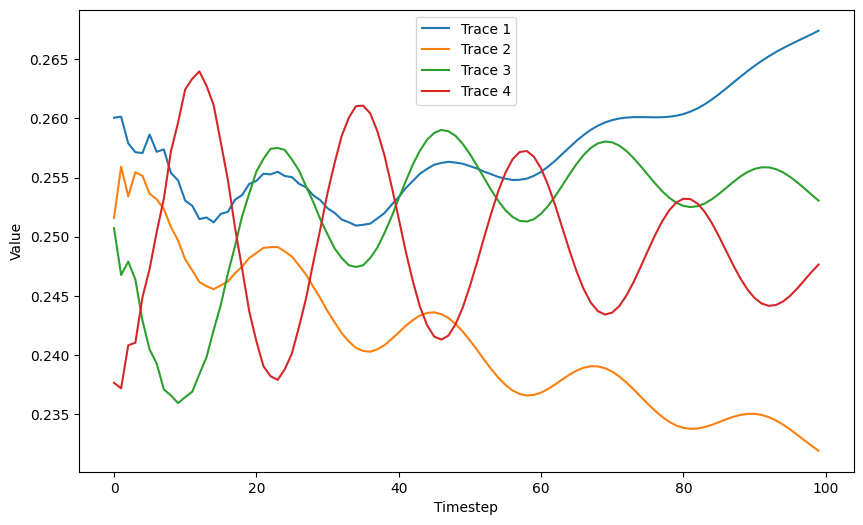

In [510]:
states = []
batch = 3
state_tensor = outputs[:,length-1,:]
batch_size = 15
transition_tensor = torch.zeros(batch_size, n_features, n_features)
for step_state in range(100):
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor[batch,:])
    

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()